In [73]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [74]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')
# Remove rows with any NaN values
df = df.dropna()

# Remove dependencies that have the same start and end dates
df = df[df['interval_start_days'] != df['interval_end_days']]
## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

df.dtypes

df.head

df.requirement_type.unique()

array(['floating-minor', 'floating-patch', 'fixed-ranging',
       'floating-major', 'pinning', 'complex-expression', 'at-most',
       'or-expression', 'not-expression'], dtype=object)

In [75]:
df.head()

,dependency_id,dependency_key,interval_start_days,interval_end_days,requirement_type,is_out_of_date,is_exposed
1,179696,CARGO|ab_glyph|ab_glyph_rasterizer,1078,1239.0,floating-minor,False,False
2,179696,CARGO|ab_glyph|ab_glyph_rasterizer,70,77.0,floating-minor,False,False
3,179696,CARGO|ab_glyph|ab_glyph_rasterizer,1001,1078.0,floating-minor,False,False
4,179696,CARGO|ab_glyph|ab_glyph_rasterizer,862,896.0,floating-minor,False,False
5,179696,CARGO|ab_glyph|ab_glyph_rasterizer,0,6.0,floating-minor,False,False


In [78]:
# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)
print(df)
print(df.requirement_type.unique())

         dependency_id                     dependency_key  \
1283874            723                PYPI|cirq|cirq-ionq   
1284612            723                PYPI|cirq|cirq-ionq   
1285234            723                PYPI|cirq|cirq-ionq   
1285671            723                PYPI|cirq|cirq-ionq   
1284393            723                PYPI|cirq|cirq-ionq   
...                ...                                ...   
1205559        1559737       CARGO|icu_datagen|num-bigint   
1205574        1559738                   NPM|svelte|tslib   
1425875        1559739           PYPI|nevergrad|py-bobyqa   
1170039        1559741            NPM|yarn|imports-loader   
1205571        1559743  NPM|react-datepicker|react-docgen   

         interval_start_days  interval_end_days requirement_type  \
1283874                    0                0.0          pinning   
1284612                    0                0.0          pinning   
1285234                    0                0.0          pinnin

## Visualizing the Dependency Requirement Types

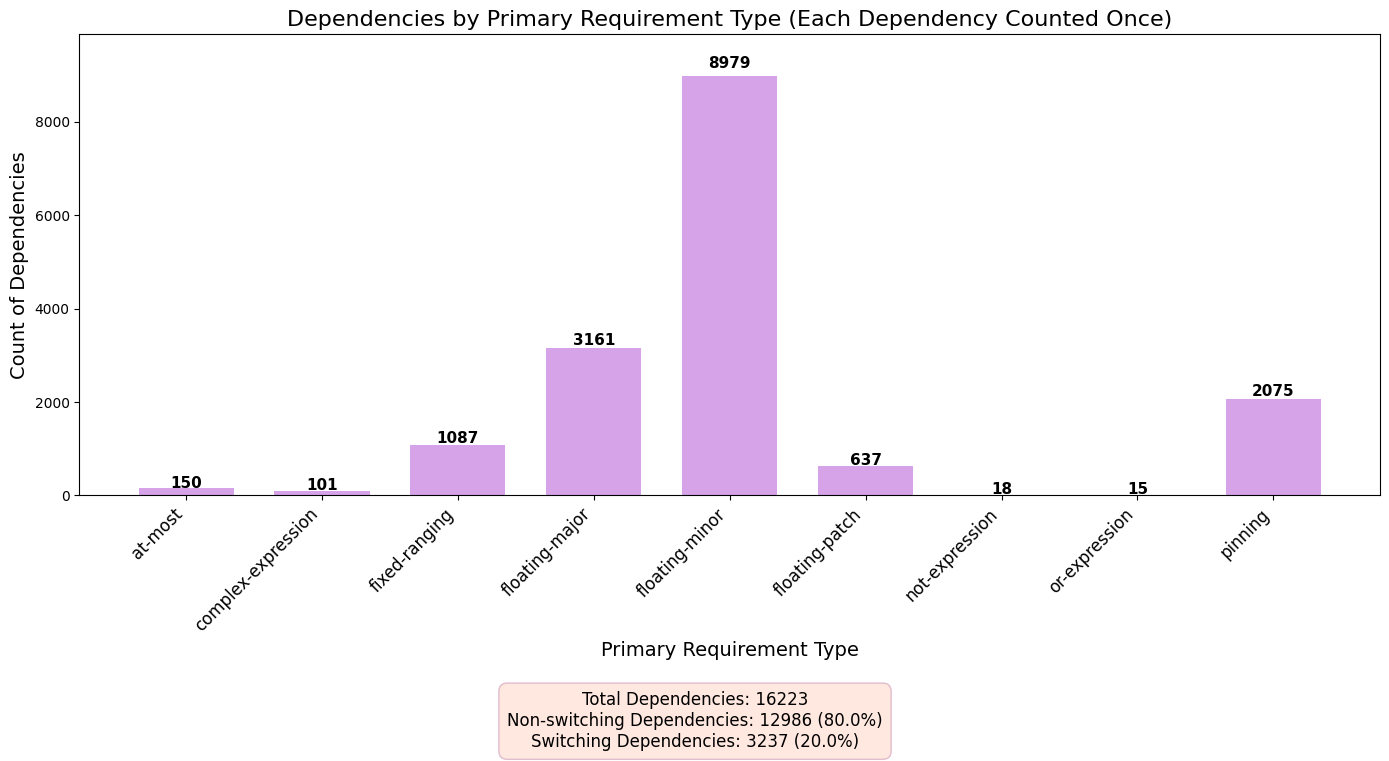

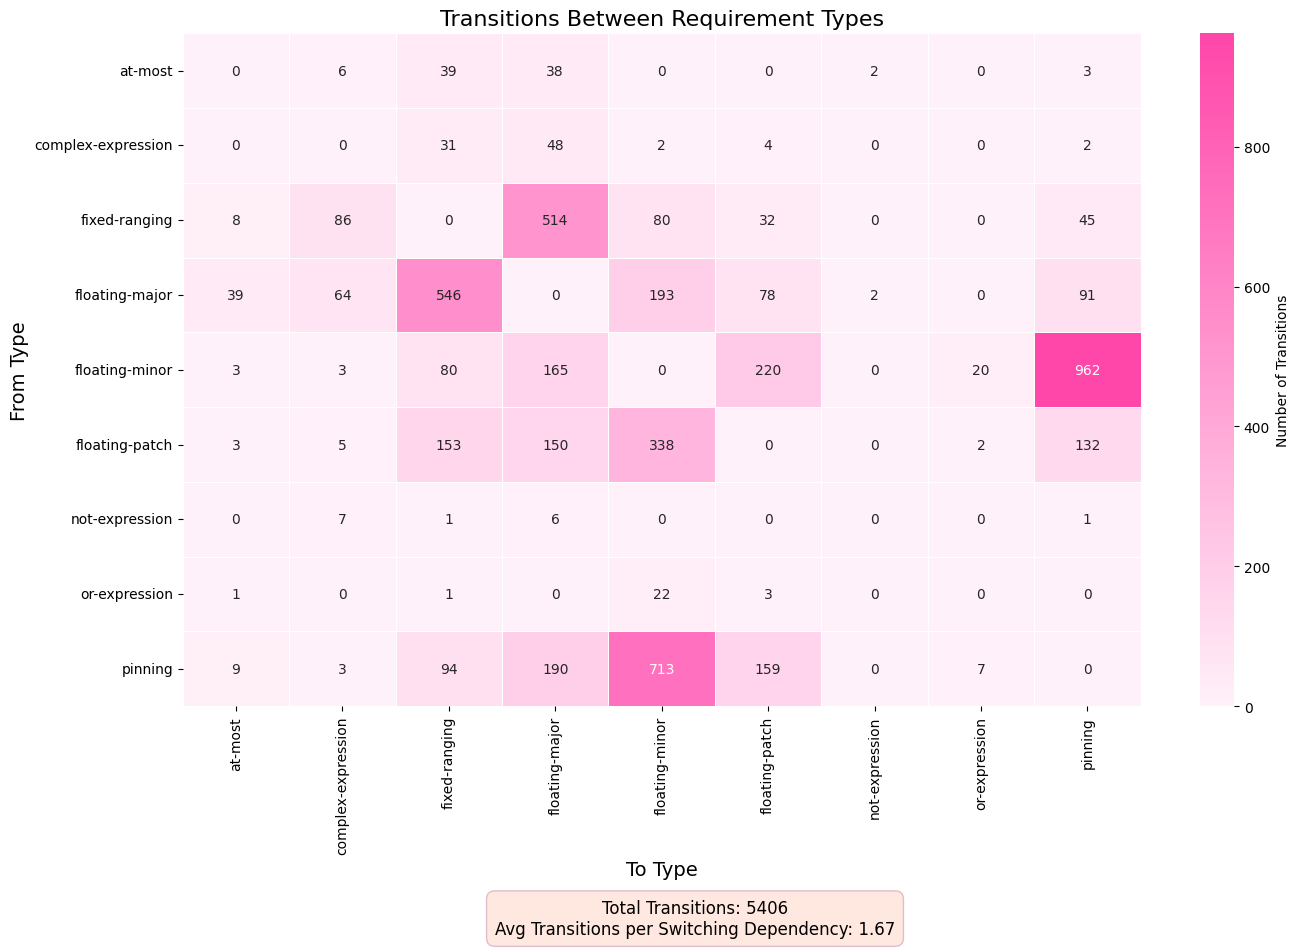

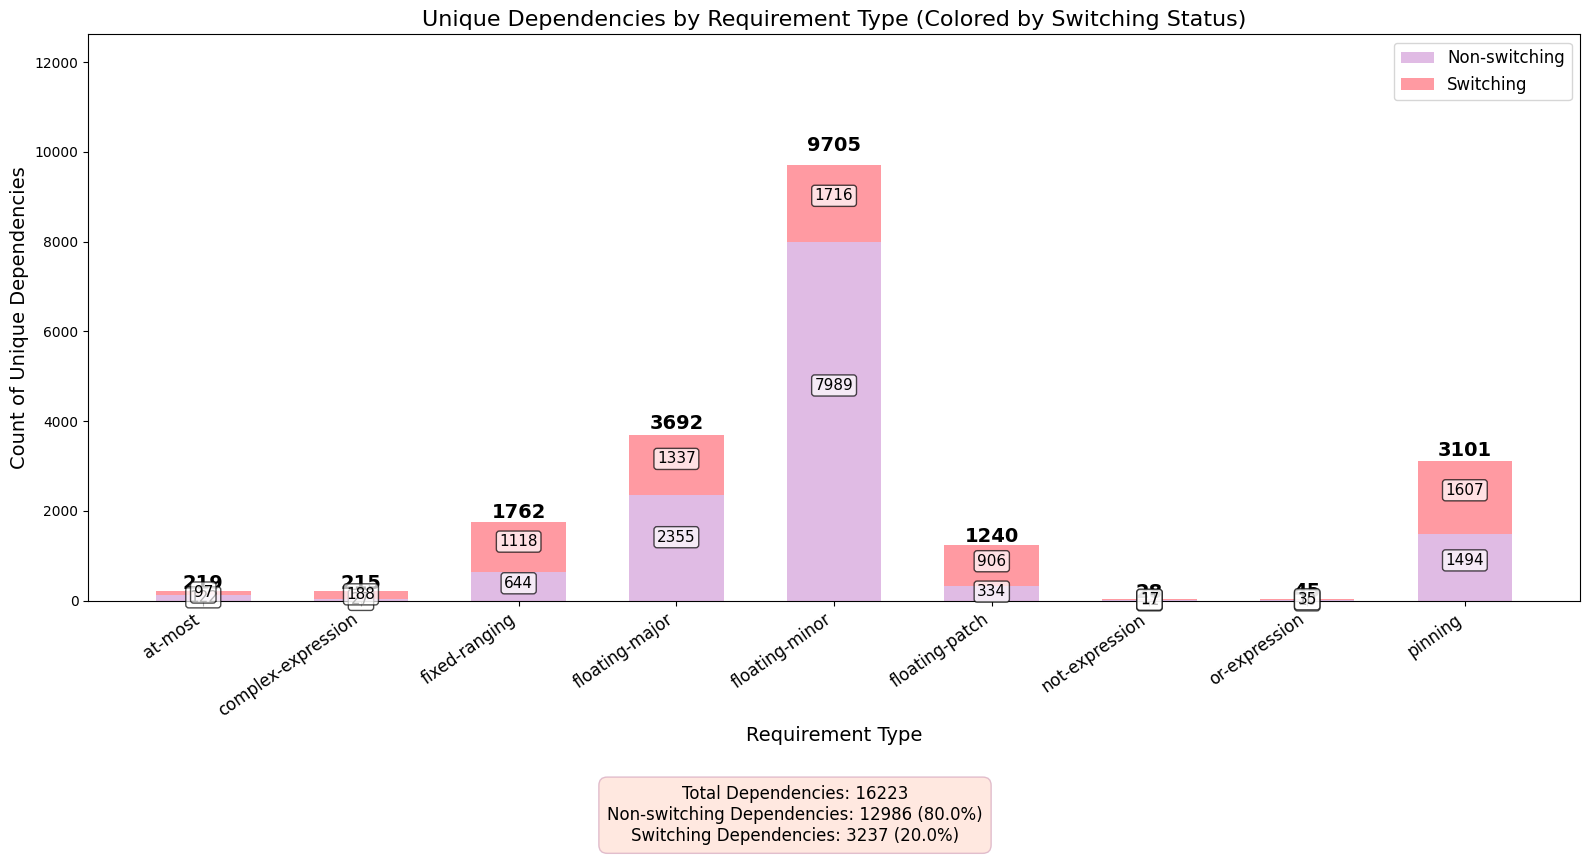

In [9]:
# Assuming df is already loaded with your data

# Part 1: Find dependencies that switch between requirement types
# Group by dependency_id and count unique requirement types
dependency_switches = df.groupby('dependency_id')['requirement_type'].nunique()
# Filter for dependencies with more than 1 requirement type
switching_deps = dependency_switches[dependency_switches > 1]
non_switching_deps = dependency_switches[dependency_switches == 1]

# Get the primary requirement type for each dependency (most common or first)
# For exclusive counts, we'll use the most frequent requirement type for each dependency
req_type_by_dep = df.groupby(['dependency_id', 'requirement_type']).size().reset_index(name='count')
primary_req_type = req_type_by_dep.sort_values(['dependency_id', 'count'], ascending=[True, False]) \
                                 .drop_duplicates('dependency_id')

# Count dependencies by their primary requirement type
exclusive_counts = primary_req_type.groupby('requirement_type').size()

# Create a DataFrame to track switching patterns
switching_patterns = pd.DataFrame(columns=['dependency_id', 'from_type', 'to_type', 'count'])

# For each switching dependency, find the transition patterns
rows = []
for dep_id in switching_deps.index:
    dep_data = df[df['dependency_id'] == dep_id]
    # Get the sequence of requirement types for this dependency
    req_sequence = dep_data['requirement_type'].tolist()
    
    # Track transitions between consecutive requirement types
    for i in range(len(req_sequence) - 1):
        from_type = req_sequence[i]
        to_type = req_sequence[i + 1]
        if from_type != to_type:  # Only count actual transitions
            rows.append({
                'dependency_id': dep_id,
                'from_type': from_type,
                'to_type': to_type,
                'count': 1
            })

if rows:
    switching_patterns = pd.DataFrame(rows)
    # Aggregate counts for same type transitions
    switching_patterns = switching_patterns.groupby(['from_type', 'to_type']).sum().reset_index()

# PLOT 1: Exclusive counts (each dependency counted only once)
plt.figure(figsize=(14, 8))

# Create a pretty pink color palette
exclusive_color = '#D6A2E8'  # Light purple

bars = plt.bar(exclusive_counts.index, exclusive_counts.values, color=exclusive_color, width=0.7)

plt.title('Dependencies by Primary Requirement Type (Each Dependency Counted Once)', fontsize=16)
plt.xlabel('Primary Requirement Type', fontsize=14)
plt.ylabel('Count of Dependencies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, max(exclusive_counts.values) * 1.1)  # Add more space at the top

# Add the count values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02) + 5,
            f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

# Add information about switching dependencies
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# PLOT 2: Transitions between requirement types with colored segments
if rows:
    # Create a pivot table for the heatmap
    pivot_data = switching_patterns.pivot_table(
        index='from_type', 
        columns='to_type', 
        values='count', 
        fill_value=0
    )
    
    plt.figure(figsize=(14, 10))
    
    # Custom pink colormap
    colors = ["#FFF1F9", "#FFDBEF", "#FFC6E5", "#FFB0DB", "#FF9AD1", "#FF85C7", "#FF70BD", "#FF5BB3", "#FF46A9"]
    cmap = LinearSegmentedColormap.from_list("pretty_pinks", colors)
    
    # Plot the heatmap with improved annotations
    ax = sns.heatmap(pivot_data, annot=True, cmap=cmap, fmt='g', linewidths=0.5,
                cbar_kws={'label': 'Number of Transitions'})
    
    # Improve the appearance
    plt.title('Transitions Between Requirement Types', fontsize=16)
    plt.xlabel('To Type', fontsize=14)
    plt.ylabel('From Type', fontsize=14)
    
    # Add legend for switching dependencies with prettier box
    total_transitions = switching_patterns['count'].sum()
    plt.figtext(0.5, 0.01, 
                f'Total Transitions: {total_transitions}\n'
                f'Avg Transitions per Switching Dependency: {total_transitions/len(switching_deps):.2f}', 
                ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# PLOT 3: Requirement type distribution colored by switching vs non-switching
# Get counts by requirement type for switching and non-switching dependencies
switching_ids = switching_deps.index.tolist()

# Create a new dataframe with dependency_id and switching status
dep_status = pd.DataFrame({
    'dependency_id': dependency_switches.index,
    'is_switching': [dep_id in switching_ids for dep_id in dependency_switches.index]
})

# Merge with the original data
df_with_status = pd.merge(df, dep_status, on='dependency_id')

# Now count unique dependencies by requirement type and switching status
switching_status_counts = df_with_status.drop_duplicates(['dependency_id', 'requirement_type']) \
                                       .groupby(['requirement_type', 'is_switching']).size() \
                                       .unstack(fill_value=0)

# Reset index to make requirement_type a column
if isinstance(switching_status_counts, pd.Series):
    # Handle case where only one switching status exists
    switching_status_counts = pd.DataFrame(switching_status_counts)
else:
    switching_status_counts = switching_status_counts.reset_index()

# Rename columns for clarity
if True in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={True: 'Switching', False: 'Non-switching'})
elif 'is_switching' in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={'is_switching': 'Switching'})
    switching_status_counts['Non-switching'] = 0

# Fill NaN with zeros
switching_status_counts = switching_status_counts.fillna(0)

# Create the stacked bar chart
plt.figure(figsize=(16, 9))
width = 0.6  # Narrower bars for more space between them

# Create a pretty pink color palette
non_switching_color = '#E0BBE4'  # Light lavender
switching_color = '#FF9AA2'     # Light pink

# Get the requirement types and values
if 'requirement_type' in switching_status_counts.columns:
    req_types = switching_status_counts['requirement_type']
    non_switching_values = switching_status_counts['Non-switching'] if 'Non-switching' in switching_status_counts.columns else 0
    switching_values = switching_status_counts['Switching'] if 'Switching' in switching_status_counts.columns else 0
else:
    # Handle multiindex case
    req_types = switching_status_counts.index
    non_switching_values = switching_status_counts[False] if False in switching_status_counts.columns else 0
    switching_values = switching_status_counts[True] if True in switching_status_counts.columns else 0

# Draw the stacked bars
plt.bar(req_types, non_switching_values, width, label='Non-switching', color=non_switching_color)
plt.bar(req_types, switching_values, width, bottom=non_switching_values, label='Switching', color=switching_color)

# Create custom annotations
for i, req_type in enumerate(req_types):
    non_switch = non_switching_values.iloc[i] if hasattr(non_switching_values, 'iloc') else non_switching_values[i]
    switch = switching_values.iloc[i] if hasattr(switching_values, 'iloc') else switching_values[i]
    total = non_switch + switch
    
    # Special handling for the problematic bar (floating-major-restrictive)
    if 'restrictive' in str(req_type):
        # Place the total high above
        plt.text(i, total + 400, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
###############################################################  
# editing the spacing around the arrows       
        # Create annotation arrows for the segments to make them clear
        # For non-switching segment
        if non_switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Non-switching: {int(non_switch)}',
                xy=(i, non_switch/2),  # Point in the middle of the segment
                xytext=(i - 0.4, non_switch/2),  # Text position 
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='right',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )
        
        # For switching segment
        if switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Switching: {int(switch)}',
                xy=(i, non_switch + switch/2),  # Point in the middle of the segment
                xytext=(i + 0.4, non_switch + switch/2),  # Text position
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='left',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )

###############################################################  
    else:
        # Regular bars - place total above
        plt.text(i, total + (total * 0.03) + 30, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
        # Add counts in the middle of each segment if large enough
        if non_switch > total * 0.08:
            plt.text(i, non_switch * 0.6, f'{int(non_switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
        
        if switch > total * 0.08:
            plt.text(i, non_switch + switch * 0.6, f'{int(switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

plt.title('Unique Dependencies by Requirement Type (Colored by Switching Status)', fontsize=16)
plt.xlabel('Requirement Type', fontsize=14)
plt.ylabel('Count of Unique Dependencies', fontsize=14)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.ylim(0, max(non_switching_values + switching_values) * 1.3)  # Extra space for annotations

plt.legend(fontsize=12, loc='upper right')

# Add information about switching dependencies with a prettier box
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

In [12]:
df.dtypes

dependency_id                            int64
dependency_key                          object
interval_start_days                      int64
interval_end_days                      float64
is_out_of_date                            bool
is_exposed                                bool
requirement_type_floating-minor           bool
requirement_type_floating-patch           bool
requirement_type_fixed-ranging            bool
requirement_type_pinning                  bool
requirement_type_complex-expression       bool
requirement_type_at-most                  bool
requirement_type_or-expression            bool
requirement_type_not-expression           bool
dtype: object

In [14]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_outdated['dependency_id'].nunique())

Number of unique dependencies:  16094


# Cox Proportional Hazards Model

In [113]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

## must remove deependencies that have the start and end dates the same
df = df[df['interval_start_days'] != df['interval_end_days']]


df.requirement_type.unique()

array(['floating-minor', 'floating-patch', 'fixed-ranging',
       'floating-major', 'pinning', 'complex-expression', 'at-most',
       'or-expression', 'not-expression'], dtype=object)

In [114]:
# Step 1: Sort by dependency_id and time
df_sorted = df.sort_values(by=['dependency_id', 'interval_start_days'])

# Step 2: Add previous requirement_type per dependency
df_sorted['prev_requirement_type'] = df_sorted.groupby('dependency_id')['requirement_type'].shift(1)

# Step 3: Filter for transitions where type changed
transitions = df_sorted[
    (df_sorted['prev_requirement_type'] == 'floating-major') &
    (df_sorted['requirement_type'] == 'pinning')
]

# Step 4: Count unique dependencies that made this transition
num_deps_transitioned = transitions['dependency_id'].nunique()
print(f"Number of dependencies that transitioned from floating-major to pinning: {num_deps_transitioned}")

Number of dependencies that transitioned from floating-major to pinning: 85


In [115]:
# Need to convert the requirement_type column to a categorical type

df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=['pinning',        # This is the baseline for one-hot encoding
                'floating-major', 
                'floating-minor',
                'floating-patch',
                'fixed-ranging',
                'complex-expression',
                'at-most',
                'or-expression',
                'not-expression'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

df.head()


,dependency_id,dependency_key,interval_start_days,interval_end_days,is_out_of_date,is_exposed,requirement_type_floating-major,requirement_type_floating-minor,requirement_type_floating-patch,requirement_type_fixed-ranging,requirement_type_complex-expression,requirement_type_at-most,requirement_type_or-expression,requirement_type_not-expression
1284393,723,PYPI|cirq|cirq-ionq,0,1.0,False,False,False,False,False,False,False,False,False,False
1284379,723,PYPI|cirq|cirq-ionq,1,2.0,False,False,False,False,False,False,False,False,False,False
1284338,723,PYPI|cirq|cirq-ionq,2,3.0,False,False,False,False,False,False,False,False,False,False
1285387,723,PYPI|cirq|cirq-ionq,3,6.0,False,False,False,False,False,False,False,False,False,False
1284064,723,PYPI|cirq|cirq-ionq,6,7.0,False,False,False,False,False,False,False,False,False,False


In [116]:
# print the column names 
print("Columns in the DataFrame:")
for col in df.columns:
    print(col)

Columns in the DataFrame:
dependency_id
dependency_key
interval_start_days
interval_end_days
is_out_of_date
is_exposed
requirement_type_floating-major
requirement_type_floating-minor
requirement_type_floating-patch
requirement_type_fixed-ranging
requirement_type_complex-expression
requirement_type_at-most
requirement_type_or-expression
requirement_type_not-expression


In [117]:
df.dtypes

dependency_id                            int64
dependency_key                          object
interval_start_days                      int64
interval_end_days                      float64
is_out_of_date                            bool
is_exposed                                bool
requirement_type_floating-major           bool
requirement_type_floating-minor           bool
requirement_type_floating-patch           bool
requirement_type_fixed-ranging            bool
requirement_type_complex-expression       bool
requirement_type_at-most                  bool
requirement_type_or-expression            bool
requirement_type_not-expression           bool
dtype: object

## Testing for perfect separation

In [120]:
covariates = [
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    'requirement_type_floating-major',
    #'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression'
]

# Loop and print cross-tabs
for cov in covariates:
    print(f"\n=== Crosstab for: {cov} ===")
    ct = pd.crosstab(df[cov], df['is_out_of_date'])
    print(ct)


=== Crosstab for: requirement_type_floating-minor ===
is_out_of_date                    False   True 
requirement_type_floating-minor                
False                            507766  103135
True                             480009  116292

=== Crosstab for: requirement_type_floating-patch ===
is_out_of_date                    False   True 
requirement_type_floating-patch                
False                            943101  201292
True                              44674   18135

=== Crosstab for: requirement_type_fixed-ranging ===
is_out_of_date                   False   True 
requirement_type_fixed-ranging                
False                           914699  198825
True                             73076   20602

=== Crosstab for: requirement_type_floating-major ===
is_out_of_date                    False   True 
requirement_type_floating-major                
False                            747531  218648
True                             240244     779

=== Crosstab for

## Model 1: is_out_of_date

/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column requirement_type_not-expression have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['is_out_of_date'].astype(bool)
>>> print(df.loc[events, 'requirement_type_not-expression'].var())
>>> print(df.loc[~events, 'requirement_type_not-expression'].var())

A very low variance means that the column requirement_type_not-expression completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.07e+00, step_size = 0.9500, log_lik = -1949843.41754, newton_decrement = 4.81e+04, seconds_since_start = 22.4
Iteration 2: norm_delta = 3.70e-01, step_size = 0.9500, log_lik = -1905613.73257, newton_decrement = 1.15e+04, seconds_since_start = 41.9
Iteration 3: norm_delta = 3.37e-01, step_size = 0.9500, log_lik = -1892461.96966, newton_decrement = 2.44e+03, seconds_since_start = 61.8
Iteration 4: norm_delta = 2.77e-01, step_size = 1.0000, log_lik = -1889558.33145, newton_decrement = 6.09e+02, seconds_since_start = 82.9
Iteration 5: norm_delta = 1.50e-01, step_size = 1.0000, log_lik = -1888835.35563, newton_decrement = 8.65e+01, seconds_since_start = 103.5
Iteration 6: norm_delta = 3.55e-02, step_size = 1.0000, log_lik = -1888739.18444, newton_decrement = 3.36e+00, seconds_since_start = 125.3
Iteration 7: norm_delta = 1.66e-03, step_size = 1.0000, log_lik = -1888735.72385, newton_decrement = 6.74e-03, seconds_since_start = 144.2
Iteration 8: norm_delta = 3.44e

<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 219427 events>
         event col = 'is_out_of_date'
number of subjects = 16094
 number of periods = 1207202
  number of events = 219427
partial log-likelihood = -1888735.72
  time fit was run = 2025-05-29 00:58:45 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
requirement_type_floating-major     -4.87      0.01      0.04           -4.94           -4.80                0.01                0.01
requirement_type_floating-minor     -0.82      0.44      0.01           -0.83           -0.81                0.43                0.44
requirement_type_floating-patch     -0.28      0.75      0.01           -0.30           -0.27                0.74                0.77
requirement_type_fixed-ranging      -0.48      0.62      0.01           -0.50           -0.47                0.61                0.63
requirement_type_complex-expression -1.43      0.24      0.04           -1.50           -1.36                0.22                0.26
requirement_type_at-most             0.00      1.00      0.02           -0.05            0.05                0.95                1.05
requirement_type_or-expression       0.66      1.94      0.03            0.60            0.72                1.82                2.06
requirement_type_not-expression     -3.28      0.04      0.22           -3.72           -2.84                0.02                0.06

                                     cmp to       z      p  -log2(p)
covariate                                                           
requirement_type_floating-major        0.00 -135.13 <0.005       inf
requirement_type_floating-minor        0.00 -163.66 <0.005       inf
requirement_type_floating-patch        0.00  -33.49 <0.005    814.43
requirement_type_fixed-ranging         0.00  -59.99 <0.005       inf
requirement_type_complex-expression    0.00  -39.97 <0.005       inf
requirement_type_at-most               0.00    0.06   0.96      0.06
requirement_type_or-expression         0.00   20.26 <0.005    300.75
requirement_type_not-expression        0.00  -14.67 <0.005    159.43
---
Partial AIC = 3777487.43
log-likelihood ratio test = 122215.40 on 8 df
-log2(p) of ll-ratio test = inf

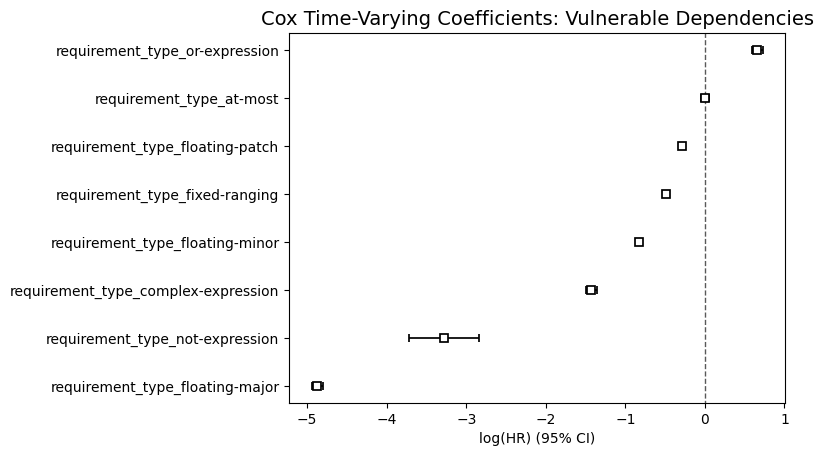

In [118]:
from lifelines import CoxTimeVaryingFitter
# Select a subset of variables
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_out_of_date',
    'requirement_type_floating-major',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression'
]

df_model_vul = df[cols_to_keep]

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vul, id_col="dependency_id", event_col="is_out_of_date", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True)
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

# **Model 2: is_exposed**

## Removing variables:

1. None of the floating-major constraint type rows have is_exposed = true 

## Testing for complete separation

In [122]:
covariates = [
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    'requirement_type_floating-major',
    #'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression'
]

# Loop and print cross-tabs
for cov in covariates:
    print(f"\n=== Crosstab for: {cov} ===")
    ct = pd.crosstab(df[cov], df['is_exposed'])
    print(ct)


=== Crosstab for: requirement_type_floating-minor ===
is_exposed                        False  True 
requirement_type_floating-minor               
False                            609617   1284
True                             595654    647

=== Crosstab for: requirement_type_floating-patch ===
is_exposed                         False  True 
requirement_type_floating-patch                
False                            1142617   1776
True                               62654    155

=== Crosstab for: requirement_type_fixed-ranging ===
is_exposed                        False  True 
requirement_type_fixed-ranging                
False                           1111974   1550
True                              93297    381

=== Crosstab for: requirement_type_floating-major ===
is_exposed                        False  True 
requirement_type_floating-major               
False                            964248   1931
True                             241023      0

=== Crosstab for: requir

## Notice that the model won't converge when we include the at-most covariate

In [126]:
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed',
   # 'requirement_type_floating-major',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
   # 'requirement_type_or-expression',
   # 'requirement_type_not-expression'
]

df_model_vuln = df[cols_to_keep]


ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vuln, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True)
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

Iteration 1: norm_delta = 1.03e+00, step_size = 0.9500, log_lik = -17163.98801, newton_decrement = 1.20e+03, seconds_since_start = 9.1
Iteration 2: norm_delta = 1.81e+02, step_size = 0.9500, log_lik = -30838.21489, newton_decrement = 2.82e+06, seconds_since_start = 15.8
Iteration 3: norm_delta = 2.36e+14, step_size = 0.0950, log_lik = -381679.10334, newton_decrement = 2.45e+18, seconds_since_start = 22.5


/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:526: RuntimeWarning: overflow encountered in exp
  phi_i = weights_at_t * np.exp(np.dot(X_at_t, beta))
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:578: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:582: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + np.dot(x_death_sum, beta) + weighted_average * np.log(denom).sum()
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:566: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/Users/jillmarley/Desktop/update-metrics/myenv/lib/pyth

ConvergenceError: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs

## Testing at-most as a single predictor - causing complete separation

In [127]:
test_cols = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_at-most']
df_test = df_model_vuln[test_cols]

ctv_test = CoxTimeVaryingFitter()
try:
    ctv_test.fit(df_test, id_col="dependency_id", event_col="is_exposed",
                start_col="interval_start_days", stop_col="interval_end_days",
                show_progress=True)
    print("At-most works alone")
    ctv_test.print_summary()
except Exception as e:
    print(f"At-most fails alone: {e}")

Iteration 1: norm_delta = 8.44e-01, step_size = 0.9500, log_lik = -17163.98801, newton_decrement = 8.23e+02, seconds_since_start = 5.3
Iteration 2: norm_delta = 2.50e+02, step_size = 0.9500, log_lik = -31550.39146, newton_decrement = 3.90e+06, seconds_since_start = 10.8
Iteration 3: norm_delta = 1.47e+16, step_size = 0.0950, log_lik = -508092.40104, newton_decrement = 1.52e+20, seconds_since_start = 16.5


/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:526: RuntimeWarning: overflow encountered in exp
  phi_i = weights_at_t * np.exp(np.dot(X_at_t, beta))
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:578: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:582: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + np.dot(x_death_sum, beta) + weighted_average * np.log(denom).sum()
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:566: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/Users/jillmarley/Desktop/update-metrics/myenv/lib/pyth

At-most fails alone: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs


## Showning quasi separation graphically

At-most event timing distribution:
count    115.000000
mean     187.773913
std      174.079235
min        4.000000
25%       49.500000
50%      125.000000
75%      305.000000
max      657.000000
Name: interval_end_days, dtype: float64


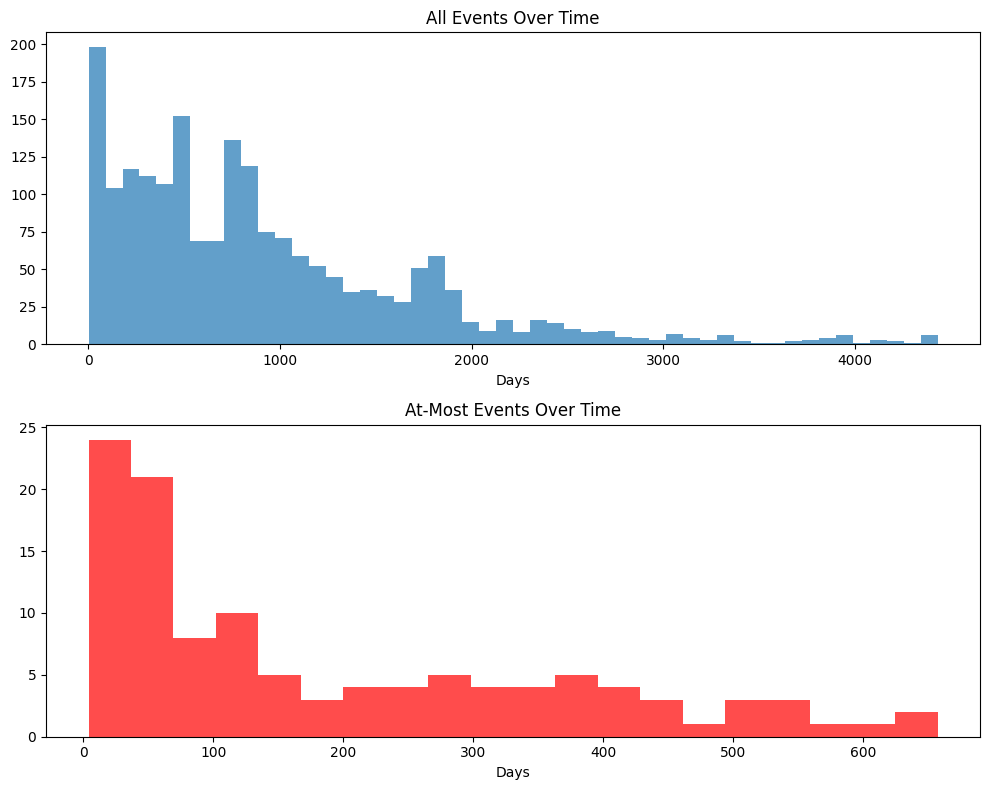


Most common event times for at-most:
interval_end_days
15.0     4
55.0     3
69.0     3
36.0     3
81.0     2
133.0    2
7.0      2
19.0     2
24.0     2
32.0     2
Name: count, dtype: int64


In [129]:
# Check if at-most subjects cluster at specific time points
at_most_events = df_model_outdated[
    (df_model_outdated['requirement_type_at-most'] == 1) & 
    (df_model_outdated['is_exposed'] == 1)
]

print("At-most event timing distribution:")
print(at_most_events['interval_end_days'].describe())

# Check for clustering
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot all events
all_events = df_model_outdated[df_model_outdated['is_exposed'] == 1]
ax1.hist(all_events['interval_end_days'], bins=50, alpha=0.7, label='All events')
ax1.set_title('All Events Over Time')
ax1.set_xlabel('Days')

# Plot at-most events
ax2.hist(at_most_events['interval_end_days'], bins=20, alpha=0.7, color='red')
ax2.set_title('At-Most Events Over Time')
ax2.set_xlabel('Days')

plt.tight_layout()
plt.show()

# Check for exact time clustering
print("\nMost common event times for at-most:")
print(at_most_events['interval_end_days'].value_counts().head(10))

Iteration 1: norm_delta = 5.61e-01, step_size = 0.9500, log_lik = -17163.98801, newton_decrement = 3.85e+02, seconds_since_start = 6.1
Iteration 2: norm_delta = 2.07e-01, step_size = 0.9500, log_lik = -16994.79046, newton_decrement = 1.10e+02, seconds_since_start = 12.5
Iteration 3: norm_delta = 3.28e-02, step_size = 0.9500, log_lik = -16878.09008, newton_decrement = 4.81e+00, seconds_since_start = 19.3
Iteration 4: norm_delta = 5.82e-03, step_size = 1.0000, log_lik = -16873.00560, newton_decrement = 1.43e-01, seconds_since_start = 26.4
Iteration 5: norm_delta = 2.05e-04, step_size = 1.0000, log_lik = -16872.85935, newton_decrement = 1.73e-04, seconds_since_start = 34.1
Iteration 6: norm_delta = 2.64e-07, step_size = 1.0000, log_lik = -16872.85917, newton_decrement = 2.88e-10, seconds_since_start = 40.7
Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 1931 events>
         event col = 'is_exposed'
number of subjects = 16094
 number of periods = 1207202
  number of events = 1931
partial log-likelihood = -16872.86
  time fit was run = 2025-05-29 01:17:40 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
requirement_type_floating-minor     -0.56      0.57      0.05           -0.67           -0.46                0.51                0.63
requirement_type_floating-patch      0.39      1.48      0.09            0.21            0.56                1.24                1.76
requirement_type_fixed-ranging       0.99      2.69      0.06            0.86            1.11                2.37                3.04
requirement_type_complex-expression  1.26      3.52      0.15            0.97            1.55                2.63                4.72

                                     cmp to      z      p  -log2(p)
covariate                                                          
requirement_type_floating-minor        0.00 -10.30 <0.005     80.29
requirement_type_floating-patch        0.00   4.37 <0.005     16.28
requirement_type_fixed-ranging         0.00  15.51 <0.005    177.91
requirement_type_complex-expression    0.00   8.43 <0.005     54.63
---
Partial AIC = 33753.72
log-likelihood ratio test = 582.26 on 4 df
-log2(p) of ll-ratio test = 411.82

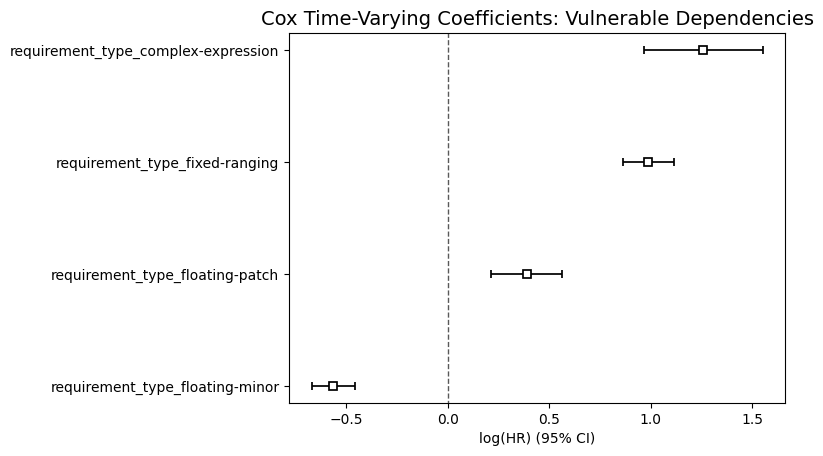

In [124]:
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed',
   # 'requirement_type_floating-major',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    'requirement_type_complex-expression',
   # 'requirement_type_at-most',
   # 'requirement_type_or-expression',
   # 'requirement_type_not-expression'
]

df_model_outdated = df[cols_to_keep]


ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_outdated, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True)
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

## dependency outdated and vulnerability rates 

In [94]:
# Total number of unique dependencies
total_dependencies = df['dependency_id'].nunique()

# Number of dependencies ever exposed
exposed_dependencies = df[df['is_exposed'] == True]['dependency_id'].nunique()

# Number of dependencies ever outdated
outdated_dependencies = df[df['is_out_of_date'] == True]['dependency_id'].nunique()

# Percentages
exposure_rate = (exposed_dependencies / total_dependencies) * 100
outdated_rate = (outdated_dependencies / total_dependencies) * 100

# Output
print(f"Total unique dependencies: {total_dependencies}")
print(f"Dependencies ever exposed: {exposed_dependencies} ({exposure_rate:.2f}%)")
print(f"Dependencies ever outdated: {outdated_dependencies} ({outdated_rate:.2f}%)")

Total unique dependencies: 16223
Dependencies ever exposed: 284 (1.75%)
Dependencies ever outdated: 8962 (55.24%)
